In [2]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import bioread
from scipy.fft import fft
from scipy import signal
from scipy.signal import find_peaks


In [3]:
def FIRrespt(ninput,xinput,nh,h):
    Nx=len(xinput);Nh=len(h);conv=np.convolve(xinput,h);n0=ninput[0]+nh[0];Nconv=Nx+Nh-1;nconv=np.arange(n0,n0 + Nconv)
    R = np.vstack((nconv,conv)).T
    return R   

def FIRrespf(w,h):
    Nh=len(h); H = 0
    for i in np.arange(Nh):
        H = H + h[i]*np.exp(-1j*w*i)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R 

def IIRrespt(xinput,c,d):
    N1 = len(xinput) # 
    nx = np.arange(-(len(c)-1),N1)
    x = xinput
    for k in np.arange(len(c)-1):
        x = np.insert(x,0,0)
    ny = np.arange(-(len(d)-1),N1)
    y = np.arange(0,len(ny),dtype=np.float64)
    for k in np.arange(len(d)-1):
        y[k] = 0
    for i in np.arange(len(d)-1,len(y)):
        z = 0
        for j in np.arange(1,len(d)):
            z = z - d[j]*y[i-j] + c[j]*x[i-j]
        y[i] = (z + c[0]* x[i])/d[0]
    R = np.vstack((ny,y)).T
    return R

def IIRrespf(w,c,d):
    Nc=len(c); Nd=len(d); Hnum = 0; Hden = 0
    for i in np.arange(Nc):
        Hnum = Hnum + c[i]*np.exp(-1j*w*i)
    for i in np.arange(Nd):
        Hden = Hden + d[i]*np.exp(-1j*w*i)
    H = np.divide(Hnum,Hden)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R

def vent(vent_name,M):
    nw = np.arange(2*M+1)
    if vent_name == 'rectangular':
        ventana = np.piecewise(nw,nw>=0,[1,0])
    elif vent_name == 'hanning':
        ventana = 0.5*(1+np.cos(2*np.pi*(nw-M)/(2*M+1)))
    elif vent_name == 'hamming':
        ventana = 0.54+0.46*np.cos(2*np.pi*(nw-M)/(2*M+1))
    elif vent_name == 'blackman':
        ventana = 0.42+0.5*np.cos(2*np.pi*(nw-M)/(2*M+1))+0.08*np.cos(4*np.pi*(nw-M)/(2*M+1))
    return np.vstack((nw,ventana)).T

def Hvent(w,ventana):
    z = 0
    for k in np.arange(len(ventana)):
        z = z + ventana[k]*np.exp(-1j*w*k)
    aux = z
    return np.vstack((w,abs(aux),np.angle(aux))).T

In [7]:
def FIR(nombreArchivo):
    ECG = bioread.read_file (nombreArchivo)
    canales = ECG.channels
    for i in np.arange (0,len(canales)):
        print (f"Canal {i}: {canales[i]}")

    canal_elegido = 0
    t = ECG.time_index.T

    señal = ECG.channels[canal_elegido].data

    N = len(señal)
    Fs = ECG.channels[canal_elegido].samples_per_second
    
#................................Elimino tendencia............................................
    A3 = np.arange(0,N,250) #arreglo
    B3 = tuple(A3) #tupla
    señal = signal.detrend(señal,bp=A3)
    
#..................................Espectro de Señal.........................................

    espectro = fft(señal)/N
    w = np.linspace(0,2*np.pi,N)
    eje_f = w*Fs/(2*np.pi)
        
#-.......................Analizo el espectro entre los 40 y 65 Hz............................

    f_min = np.where(eje_f>40)
    f_max = np.where((eje_f>40)&(eje_f<65))
    
    f_m = f_min[0][0] #frecuencia mínima de analisis
    f_M = f_max[0][len(f_max[0])-1] #frecuencia máxima de análisis
    
    #...Determino cual es el valor de mi frecuencia de ruido...    
    vm = np.where(abs(espectro)[f_m:f_M]==np.max(abs(espectro)[f_m:f_M]))
    f_r = eje_f[f_m+vm[0][0]] #frecuencia de ruido
    
#..........................Determino los valores de frecuencias de corte.....................
    
    fc1 = (f_r - 5);    fc2 = (f_r + 5)
    
    wc1 = 2*np.pi*fc1/Fs;    wc2 = 2*np.pi*fc2/Fs
    
#...............................Coeficientes de pasa banda ideal.............................
    n_f = np.arange(-500, 500, dtype=float)
    
    h_bs = np.piecewise(n_f, [n_f == 0],[lambda n_f: 1-(wc2-wc1)/np.pi,
                                         lambda n_f: -(np.sin(wc2*n_f)-np.sin(wc1*n_f))/(np.pi*n_f)])

    ventana_nombre = 'rectangular'
    M = [40,80,200,400] #---Semiancho de las ventanas
    
    Mejores_S = []; Mejor_SNR = []
    
#............Para cada tipo de ventana elijo la mejor señal de acuerdo a la SNR

    Orden = np.zeros(len(M))
    señales = []
    SNRs = np.zeros(len(M))
    Atenuaciones = np.zeros(len(M))
    
    for j in range(len(M)):
        m = M[j]
        vent_BP = vent(ventana_nombre,m)
#................................Desplazo los coeficientes......................................
        n_desp = np.arange(2*m+1,dtype=float)
        h_desp = np.piecewise(n_desp, 
                              [n_desp == m],
                              [lambda n_desp: 1-(wc2-wc1)/np.pi,
                               lambda n_desp: -(np.sin(wc2*(n_desp-m))-np.sin(wc1*(n_desp-m)))/(np.pi*(n_desp-m))])
        Hw2 = 0
        for i in range(len(n_desp)):
            Hw2 = Hw2 + (vent_BP[:,1][i] * h_desp[i]* np.exp(-1j*w*n_desp[i]))
        
            
        señal_filtrada = FIRrespt(t*Fs,señal,n_desp,h_desp)[:,1]
        señal_filtrada=señal_filtrada[m:len(señal_filtrada)-1]
            
#............................Analisis de atenuacion.............................................
        peaks_max_signal = find_peaks(señal,distance=500)[0]
        peaks_min_signal = find_peaks(-señal,distance=500)[0]
        A_max_signal = np.mean(señal[peaks_max_signal])
        A_min_signal = np.mean(señal[peaks_min_signal])

        peaks_max = find_peaks (señal_filtrada,distance=500)[0]
        peaks_min = find_peaks (-señal_filtrada,distance=500)[0]
        A_max = np.mean(señal_filtrada[peaks_max])
        A_min = np.mean(señal_filtrada[peaks_min])


        A_signal = A_max_signal - A_min_signal
        A_signal_filtr = A_max - A_min


        Atenuacion = np.round((A_signal-A_signal_filtr)*100/A_signal,1)


#........................................SNR...................................................
        max_noise = max(señal_filtrada[800:1000])
        min_noise = min(señal_filtrada[800:1000])

        A_noise = max_noise - min_noise
        SNR = np.mean(A_signal_filtr) / A_noise
        SNR_dB = 20*np.log10(SNR)
    
        Orden[j] = m*2 
        señales.append(señal_filtrada)
        SNRs[j] = SNR
        Atenuaciones[j] = Atenuacion
          
#...................Elijo las señales con atenuacion <20%.....................................

    mf = np.where(Atenuaciones<20)[0]
    
    Orden_n = np.zeros(len(mf))
    señales_n = []
    SNRs_n = np.zeros(len(mf))
    Atenuaciones_n = np.zeros(len(mf)) 
    
    for i in range(len(mf)):
        Orden_n[i] = Orden[mf[i]]
        señales_n.append(señales[mf[i]])
        SNRs_n[i] = SNRs[mf[i]]
        Atenuaciones_n[i] = Atenuaciones[mf[i]]
    
#..........De las señales obtenidas, determino la que tiene mayor relacion SNR
 
    mK = np.where(SNRs_n==np.max(SNRs_n))[0][0]
    MEJOR_SEÑAL_Orden = Orden_n[mK]
    MEJOR_SEÑAL_data = señales_n[mK] 
    MEJOR_SEÑAL_SNR = SNRs_n[mK]
    MEJOR_SEÑAL_ATENUACION = Atenuaciones_n[mK]

   
    plt.figure(figsize=(20,4))
    plt.plot(t,señal,'k')
    plt.plot((np.arange(len(MEJOR_SEÑAL_data)))/Fs, MEJOR_SEÑAL_data, 'y')
    plt.legend(('señal original',('Filtrado con Ventana Rectangular orden',MEJOR_SEÑAL_Orden,'')))
    plt.xlabel('t(seg)', fontsize=12)
    plt.grid()
    plt.show()
    
    print('SNR:',20*np.log10(MEJOR_SEÑAL_SNR),'dB')
    print('Atenuacion:',MEJOR_SEÑAL_ATENUACION,'%')

Canal 0: Channel ECG (.05 - 150 Hz): 20167 samples, 1000.0 samples/sec, loaded: True


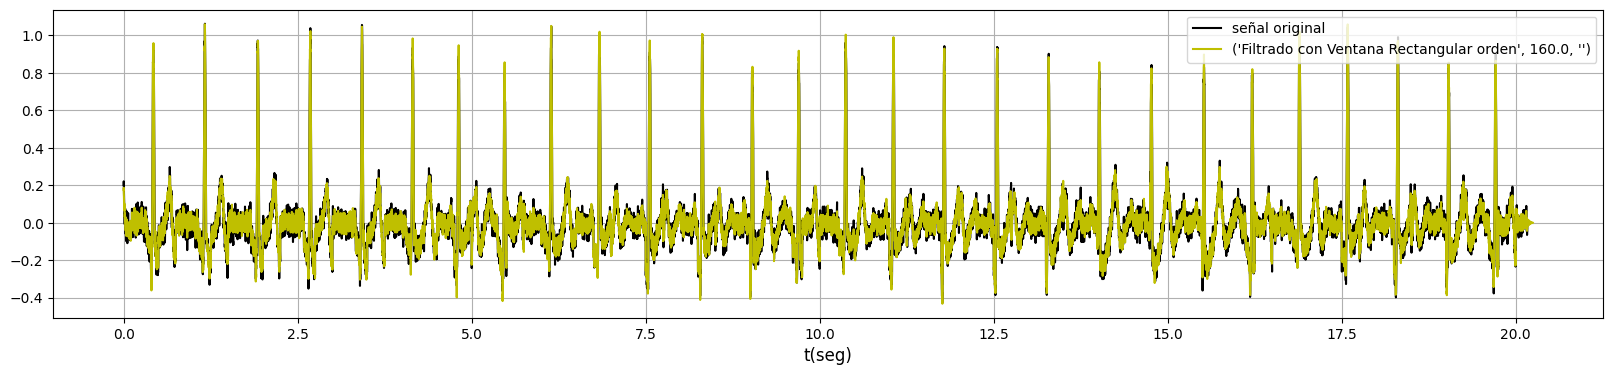

SNR: 17.44469476013321 dB
Atenuacion: 1.9 %


In [8]:
FIR('/Users/paulaaguirrecarol/Desktop/Copia de 2. ecg_sinf.acq')